# **PFE: Solution of differential equations PDEs**

### **PART 1 : Solving partial differential equations using deep learning 'Neural networks' with SciANN library**

#### **The second type of equations is Navier-Stokes equation**

   * **Importing libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sciann as sn
from scipy import io

---------------------- SCIANN 0.6.5.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)] 



* **Load the data**

In [2]:
df = io.loadmat('cylinder_nektar_wake')
for key, value in df.items() :
    print(key) 

__header__
__version__
__globals__
X_star
t
U_star
p_star


In [3]:
print(f"x_star_shape : {df['X_star'].shape}")
print(f"t_shape : {df['t'].shape}")
print(f"u_star_shape : {df['U_star'].shape}")
print(f"p_star_shape : {df['p_star'].shape}")

x_star_shape : (5000, 2)
t_shape : (200, 1)
u_star_shape : (5000, 2, 200)
p_star_shape : (5000, 200)


* **Prepare the data**

In [4]:
def prepareData(n_data= 5000, random=True):
    
    U_star = df['U_star'] 
    P_star = df['p_star'] 
    t_star = df['t'] 
    X_star = df['X_star'] 
    
    N = X_star.shape[0] # 5000
    T = t_star.shape[0] # 200
    
    # Rearrange data
    XX = np.tile(X_star[:,0], (1,T)) # it shape 5000 x 200
    YY = np.tile(X_star[:,1], (1,T)) # it shape 5000 x 200
    TT = np.tile(t_star, (1,N)).T # it shape 5000 x 200
    
    UU = U_star[:,0,:] # it shape 5000 x 200
    VV = U_star[:,1,:] # it shape 5000 x 200
    PP = P_star # it shape 5000 x 200
    
    # Pick random df.
    if random:
        idx = np.random.choice(N*T, n_data, replace=False) # choice a 5000 features from N*T = 1000000 features
    else:
        idx = np.arange(0, N*T)
    
    x = XX.flatten()[idx,None] # NT x 1  ===> 5000 * 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU.flatten()[idx,None] # NT x 1 # flatten() reshape array from n-dim to one dim
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
 
    return (x,y,t,u,v,p)

In [5]:
x_train, y_train, t_train, u_train, v_train, p_train = prepareData()

* **Step 2: Setting up the neural network**

In [6]:
x = sn.Variable('x', dtype='float64')
t = sn.Variable('t', dtype='float64')
y = sn.Variable('y', dtype='float64')

In [7]:
# Generate the outputs and the structure of networks
p = sn.Functional('p', [x,y,t], 8*[20], 'tanh')
psi = sn.Functional('psi', [x,y,t], 8*[20], 'tanh')

In [8]:
u = sn.diff(psi, y)
v = -sn.diff(psi, x)

p_x = sn.diff(p, x)
p_y = sn.diff(p, y)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_xx = sn.diff(u, x, order=2)
u_y = sn.diff(u, y)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_xx = sn.diff(v, x, order=2)
v_y = sn.diff(v, y)
v_yy = sn.diff(v, y, order=2)

In [9]:
lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")

In [10]:
# Tie class to constrain network outputs. constraint: cond1 - cond2 == sol.
c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy))
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy))
c3 = sn.Data(u_x + v_y)
c4 = psi*0.0
# Data class to impose to the system.
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(p)

In [11]:
# Define the optimization model (set of inputs and constraints)
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[d1, d2, d3, c1, c2, c3, c4],
    loss_func="mse",
    plot_to_file='NS-Model2.png'
)

In [12]:
training_history = model.train(
    [x_train, y_train, t_train], 
    [u_train, v_train, p_train, 'zeros', 'zeros', 'zeros', 'zeros'], 
    epochs=100,
    batch_size=100,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=1
    )
    
model.save_weights('trained-navier-stokes.hdf5')


Total samples: 5000 
Batch size: 100 
Total batches: 50 

Epoch 1/100
50/50 [==============================] - 36s 43ms/step - batch: 24.5000 - size: 100.0000 - loss: 0.8544 - Grad__loss: 0.6839 - mul_loss: 0.0795 - p_loss: 0.0113 - sub_2_loss: 0.0550 - sub_4_loss: 0.0247 - add_7_loss: 3.3266e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 35.9704
Epoch 2/100
50/50 [==============================] - 2s 40ms/step - batch: 24.5000 - size: 100.0000 - loss: 0.6245 - Grad__loss: 0.4405 - mul_loss: 0.0838 - p_loss: 0.0098 - sub_2_loss: 0.0669 - sub_4_loss: 0.0236 - add_7_loss: 7.8629e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 1.9910
Epoch 3/100
50/50 [==============================] - 2s 42ms/step - batch: 24.5000 - size: 100.0000 - loss: 0.4482 - Grad__loss: 0.2670 - mul_loss: 0.0913 - p_loss: 0.0098 - sub_2_loss: 0.0608 - sub_4_loss: 0.0193 - add_7_loss: 1.3550e-33 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 2.1107
Epoch 4/100
50/50 [==============================] - 2s 40ms

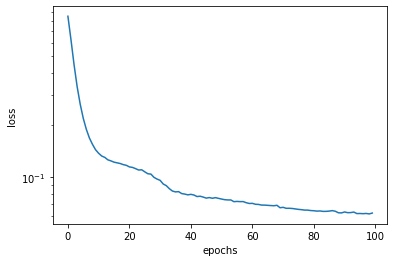

In [33]:
plt.semilogy(training_history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig("lossNavier.png", format='png', bbox_inches="tight")

In [46]:
u_pred = u.eval(model, [x_train, y_train, t_train])
v_pred = v.eval(model, [x_train, y_train, t_train])
p_pred = p.eval(model, [x_train, y_train, t_train])

### Plotting the results

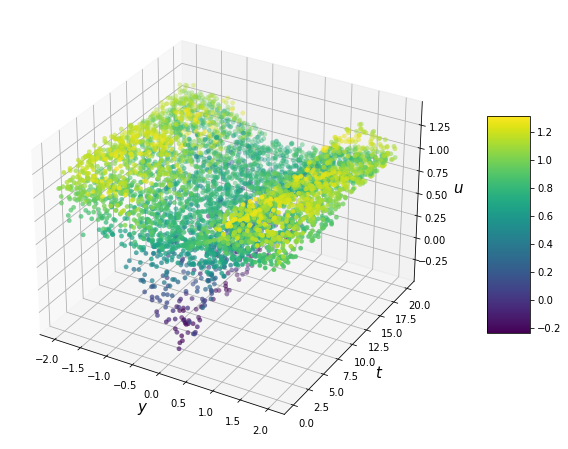

In [40]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter3D(y_train, t_train, u_pred, c=u_train, cmap='viridis',linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$y$', fontsize=15)
ax.set_ylabel('$t$', fontsize=15)
ax.set_zlabel('$u$', fontsize=15)
plt.show()

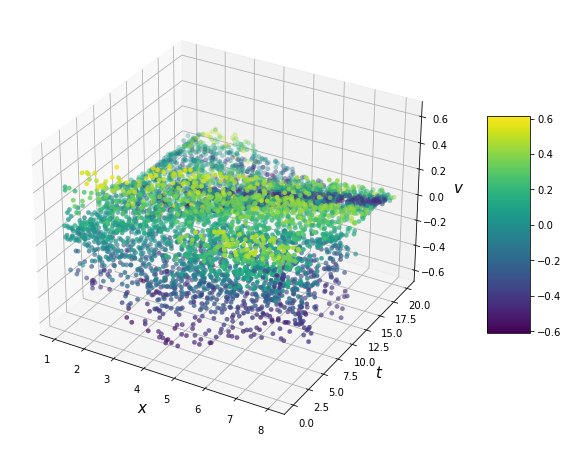

In [42]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter3D(x_train, t_train, v_pred, c=v_train, cmap='viridis',linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$t$', fontsize=15)
ax.set_zlabel('$v$', fontsize=15)
plt.show()

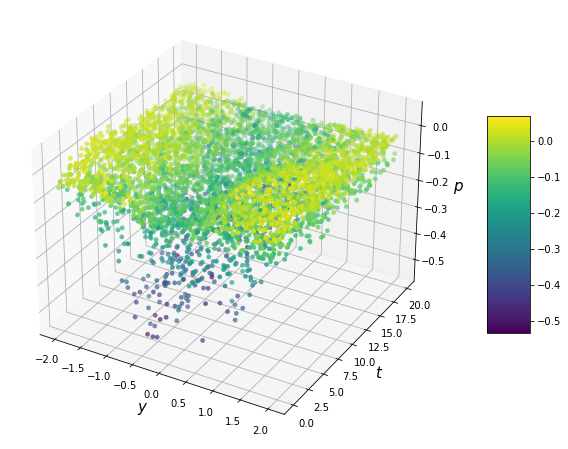

In [47]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter3D(y_train, t_train, p_pred, c=p_train, cmap='viridis',linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$y$', fontsize=15)
ax.set_ylabel('$t$', fontsize=15)
ax.set_zlabel('$p$', fontsize=15)
plt.show()